In [2]:
%load_ext autoreload
%autoreload 2

## Imports

In [3]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import sklearn.linear_model
import scipy.optimize
import sklearn.decomposition
import sklearn.manifold
import sklearn.model_selection

In [4]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [5]:
path_to_simclr_hchs = os.path.dirname(os.path.dirname(os.getcwd()))
path_to_hchs_dataset = os.path.join(os.path.dirname(path_to_simclr_hchs), "Datasets", "hchs")
path_to_actigraphy_data = os.path.join(path_to_hchs_dataset, "actigraphy")
path_to_baseline_dataset = os.path.join(path_to_hchs_dataset, "datasets", "hchs-sol-baseline-dataset-0.5.0.csv")
path_to_sueno_dataset = os.path.join(path_to_hchs_dataset, "datasets", "hchs-sol-sueno-ancillary-dataset-0.5.0.csv")
dataset_save_path = os.path.join(path_to_simclr_hchs, "PickledData", "hchs")
user_dataset_path = os.path.join(dataset_save_path, "user_dataset_resized.pickle")

In [59]:
disease_labels = {'diabetes': {1: 'Non-diabetic', 2: 'Pre-diabetic', 3: 'Diabetic'}, 'sleep_apnea': {0: 'No', 1: 'Yes'}, 'hypertension': {0: 'No', 1: 'Yes'}, 'metabolic_syndrome': {0: 'No', 1: 'Yes'}, 'insomnia': {1: 'No clinically significant insomnia', 2: 'Subthreshold insomnia', 3: 'Clinical insomnia'}, 'gender': {0: 'female', 1: 'male'}}


## Create features

In [6]:
with open(user_dataset_path, 'rb') as f:
    user_dataset = pickle.load(f)

sample_key = 163225

In [7]:
def convert_to_features(data):
    data = pd.DataFrame(data).describe()
    data_no_count = data.iloc[1:]
    data_list = []
    for i in range(7):
        for j in range(5):
            data_list.append(data_no_count.iloc[(i,j)])

    return data_list

In [8]:
user_dataset_features = {}
for user in tqdm.tqdm(user_dataset.keys()):
    data = user_dataset[user][0]
    features = convert_to_features(data)
    user_dataset_features[user] = features

100%|██████████| 1886/1886 [00:30<00:00, 61.52it/s]


In [9]:
print(pd.DataFrame(user_dataset[sample_key][0]).describe())

                  0              1             2             3             4
count  22308.000000   22308.000000  22308.000000  22308.000000  22308.000000
mean     115.921373     383.051867     14.933610     37.834218     17.100864
std      167.824522    3465.788085    135.958883    344.837991    159.579742
min        0.000000       0.000000      0.000000      0.000000      0.000000
25%        0.000000       0.360000      0.012800      0.037800      0.017300
50%       30.000000       0.730000      0.038600      0.069400      0.023500
75%      183.000000     110.600000      5.510000     10.800000      3.730000
max     1300.000000  138812.600000   5900.000000  13700.000000   6290.000000


In [10]:

column_names = ['mean_activity', 'mean_whitelight', 'mean_bluelight', 'mean_greenlight', 'mean_redlight',
            'std_activity', 'std_whitelight', 'std_bluelight', 'std_greenlight', 'std_redlight',
            'min_activity', 'min_whitelight', 'min_bluelight', 'min_greenlight', 'min_redlight',
            '25%_activity', '25%_whitelight', '25%_bluelight', '25%_greenlight', '25%_redlight',
            '50%_activity', '50%_whitelight', '50%_bluelight', '50%_greenlight', '50%_redlight',
            '75%_activity', '75%_whitelight', '75%_bluelight', '75%_greenlight', '75%_redlight',
            'max_activity', 'max_whitelight', 'max_bluelight', 'max_greenlight', 'max_redlight']
features_dataframe = pd.DataFrame.from_dict(user_dataset_features, orient='index',columns=column_names)

In [11]:
features_dataframe

,mean_activity,mean_whitelight,mean_bluelight,mean_greenlight,mean_redlight,std_activity,std_whitelight,std_bluelight,std_greenlight,std_redlight,...,75%_activity,75%_whitelight,75%_bluelight,75%_greenlight,75%_redlight,max_activity,max_whitelight,max_bluelight,max_greenlight,max_redlight
163225,115.921373,383.051867,14.933610,37.834218,17.100864,167.824522,3465.788085,135.958883,344.837991,159.579742,...,183.0,110.6000,5.51,10.800,3.730,1300.0,138812.60,5900.0,13700.0,6290.0
238589,56.564898,7.462819,0.575399,0.683183,0.191471,111.705283,36.322765,2.042594,3.479720,1.441884,...,56.0,4.5000,0.52,0.337,0.044,1057.0,3987.30,192.0,385.0,176.0
258857,93.542792,17.872076,1.519750,1.589258,0.546151,134.320722,60.684725,3.947900,5.899600,2.420843,...,155.0,10.7200,1.26,0.785,0.139,1151.0,1717.89,92.1,176.0,71.0
306064,165.438751,1180.183095,53.783077,114.850219,50.651734,184.968373,6420.250879,293.712497,628.219549,292.895020,...,257.0,93.1700,7.47,7.970,2.320,2460.0,173355.70,6710.0,17000.0,8520.0
311734,89.433961,504.188516,24.532505,48.931752,19.548203,114.603065,4911.529041,233.469564,480.462436,198.860449,...,150.0,62.2675,3.81,5.760,1.910,1860.0,160910.60,6860.0,16000.0,7320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99858115,135.388281,886.853182,40.934803,86.207475,37.864016,153.407855,6191.155475,277.397914,607.407946,276.972435,...,226.0,71.6400,5.88,6.560,1.790,1402.0,159008.40,6570.0,15600.0,7810.0
99894609,85.214569,1559.888599,77.050215,149.961295,69.621075,112.616566,9201.582716,452.514943,910.831160,412.644931,...,135.0,88.3300,5.39,8.320,2.640,1451.0,186219.30,9090.0,19800.0,11800.0
99907952,84.064178,21.934835,2.124786,1.890390,0.627092,111.440199,119.579894,7.475659,11.346286,5.172985,...,134.0,11.8700,1.67,0.856,0.151,1860.0,8925.89,420.0,858.0,448.0
99973984,83.893093,139.551356,7.065956,13.553780,4.759576,114.878930,1737.679198,99.370143,167.383326,59.979694,...,134.0,33.0700,2.76,2.760,0.410,955.0,115919.80,6860.0,11000.0,3660.0


## Get baseline and sueno data

In [12]:
baseline_data = pd.read_csv(path_to_baseline_dataset, dtype={"HEIGHT": float, "AGE":float, "BMI": float, "GENDER": str, "METS_NCEP":float, "HYPERTENSION":float, "DIABETES3":float, "AHI_GE15":float}, low_memory=False)
baseline_dataset_filtered = baseline_data[baseline_data['pid'].isin(user_dataset_features.keys())]

columns_of_interest = ["pid", "AGE", "GENDERNUM", "HEIGHT", "BMI", "DIABETES3", "HYPERTENSION", "AHI_GE15", "METS_NCEP"]

baselined_dataset_filtered_cols_of_interest = baseline_dataset_filtered[[c for c in baseline_dataset_filtered.columns if c in columns_of_interest]]

In [20]:
sueno_dataset = pd.read_csv(path_to_sueno_dataset, low_memory=False)
sueno_dataset_filtered = sueno_dataset[sueno_dataset['PID'].isin(user_dataset_features.keys())]

columns_of_interest = ["PID", "ISI_C4"]

sueno_dataset_filtered_cols_of_interest = sueno_dataset_filtered[[c for c in sueno_dataset_filtered.columns if c in columns_of_interest]]
sueno_dataset_filtered_cols_of_interest['ISI_C4'] = sueno_dataset_filtered_cols_of_interest['ISI_C4'].map({1.0:1.0, 2.0:2.0,3.0:3.0, 4.0:3.0})
sueno_dataset_filtered_cols_of_interest

,PID,ISI_C4
1,163225,1.0
2,238589,2.0
3,258857,3.0
4,306064,1.0
5,311734,3.0
...,...,...
2247,99858115,1.0
2248,99894609,3.0
2249,99907952,1.0
2250,99973984,1.0


In [21]:
baseline_sueno_merged = baselined_dataset_filtered_cols_of_interest.set_index('pid').join(sueno_dataset_filtered_cols_of_interest.set_index('PID'))
baseline_sueno_merged["PID"] = baseline_sueno_merged.index

In [22]:
baseline_sueno_merged

,HEIGHT,AGE,BMI,HYPERTENSION,DIABETES3,AHI_GE15,GENDERNUM,METS_NCEP,ISI_C4,PID
pid,,,,,,,,,,
163225,162.0,29.0,34.026825,1.0,1.0,0.0,0.0,1.0,1.0,163225
238589,175.0,62.0,30.367347,1.0,3.0,1.0,1.0,1.0,2.0,238589
258857,162.0,57.0,33.683890,0.0,2.0,0.0,0.0,0.0,3.0,258857
306064,172.0,52.0,24.337480,0.0,1.0,0.0,1.0,0.0,1.0,306064
311734,148.0,52.0,48.164719,0.0,1.0,0.0,0.0,1.0,3.0,311734
...,...,...,...,...,...,...,...,...,...,...
99858115,157.0,51.0,35.701245,0.0,3.0,0.0,0.0,1.0,1.0,99858115
99894609,164.0,55.0,24.985128,0.0,3.0,0.0,1.0,0.0,3.0,99894609
99907952,166.0,56.0,28.741472,0.0,3.0,0.0,1.0,1.0,1.0,99907952


## merge baseline_sueno and features 

In [23]:
baseline_sueno_features_merged = baseline_sueno_merged.set_index('PID').join(features_dataframe.set_index(features_dataframe.index))
print(baseline_sueno_features_merged.shape)

(1886, 44)


In [52]:
baseline_sueno_features_merged_no_na = baseline_sueno_features_merged.dropna()
baseline_sueno_features_merged_no_na = baseline_sueno_features_merged_no_na.rename(columns={'DIABETES3':'diabetes',
                                                                                            'METS_NCEP':'metabolic_syndrome',
                                                                                            'ISI_C4':'insomnia',
                                                                                            'HYPERTENSION':'hypertension',
                                                                                            'AHI_GE15':'sleep_apnea'})
baseline_sueno_features_merged_no_na

,HEIGHT,AGE,BMI,hypertension,diabetes,sleep_apnea,GENDERNUM,metabolic_syndrome,insomnia,mean_activity,...,75%_activity,75%_whitelight,75%_bluelight,75%_greenlight,75%_redlight,max_activity,max_whitelight,max_bluelight,max_greenlight,max_redlight
PID,,,,,,,,,,,,,,,,,,,,,
163225,162.0,29.0,34.026825,1.0,1.0,0.0,0.0,1.0,1.0,115.921373,...,183.0,110.6000,5.51,10.800,3.730,1300.0,138812.60,5900.0,13700.0,6290.0
238589,175.0,62.0,30.367347,1.0,3.0,1.0,1.0,1.0,2.0,56.564898,...,56.0,4.5000,0.52,0.337,0.044,1057.0,3987.30,192.0,385.0,176.0
258857,162.0,57.0,33.683890,0.0,2.0,0.0,0.0,0.0,3.0,93.542792,...,155.0,10.7200,1.26,0.785,0.139,1151.0,1717.89,92.1,176.0,71.0
306064,172.0,52.0,24.337480,0.0,1.0,0.0,1.0,0.0,1.0,165.438751,...,257.0,93.1700,7.47,7.970,2.320,2460.0,173355.70,6710.0,17000.0,8520.0
311734,148.0,52.0,48.164719,0.0,1.0,0.0,0.0,1.0,3.0,89.433961,...,150.0,62.2675,3.81,5.760,1.910,1860.0,160910.60,6860.0,16000.0,7320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99858115,157.0,51.0,35.701245,0.0,3.0,0.0,0.0,1.0,1.0,135.388281,...,226.0,71.6400,5.88,6.560,1.790,1402.0,159008.40,6570.0,15600.0,7810.0
99894609,164.0,55.0,24.985128,0.0,3.0,0.0,1.0,0.0,3.0,85.214569,...,135.0,88.3300,5.39,8.320,2.640,1451.0,186219.30,9090.0,19800.0,11800.0
99907952,166.0,56.0,28.741472,0.0,3.0,0.0,1.0,1.0,1.0,84.064178,...,134.0,11.8700,1.67,0.856,0.151,1860.0,8925.89,420.0,858.0,448.0


## tSNE 

In [54]:
features = column_names
X = baseline_sueno_features_merged_no_na[features].values

for k in range(len(features)):
    std = np.std(X[:,k])
    if std==0.0:
        continue
    else:
        X[:,k] = (X[:,k] / np.std(X[:,k]))

print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

False
True


In [55]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=50)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1851 samples in 0.012s...
[t-SNE] Computed neighbors for 1851 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1851
[t-SNE] Computed conditional probabilities for sample 1851 / 1851
[t-SNE] Mean sigma: 1.090374
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.554337
[t-SNE] KL divergence after 1000 iterations: 1.197334


In [76]:
def plot_tsne_color_coded_by_condition(disease, perplexity,disease_labels,tsne_results=False):
    labels_full_name = disease_labels[disease]
    distinct_condition_values = np.unique(baseline_sueno_features_merged_no_na[disease])
    distinct_colors = sns.color_palette("hsv", len(distinct_condition_values))
    color_dict = {condition:color for condition, color in zip(distinct_condition_values, distinct_colors)}
    cvec = [color_dict[c] for c in baseline_sueno_features_merged_no_na[disease]]

    features = ['mean_activity', 'mean_whitelight', 'mean_bluelight', 'mean_greenlight', 'mean_redlight',
            'std_activity', 'std_whitelight', 'std_bluelight', 'std_greenlight', 'std_redlight',
            'min_activity', 'min_whitelight', 'min_bluelight', 'min_greenlight', 'min_redlight',
            '25%_activity', '25%_whitelight', '25%_bluelight', '25%_greenlight', '25%_redlight',
            '50%_activity', '50%_whitelight', '50%_bluelight', '50%_greenlight', '50%_redlight',
            '75%_activity', '75%_whitelight', '75%_bluelight', '75%_greenlight', '75%_redlight',
            'max_activity', 'max_whitelight', 'max_bluelight', 'max_greenlight', 'max_redlight']
    X = baseline_sueno_features_merged_no_na[features].values

    for k in range(len(features)):
        std = np.std(X[:,k])
        if std==0.0:
            continue
        else:
            X[:,k] = (X[:,k] / np.std(X[:,k]))
    if not tsne_results.any():
        tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=perplexity)
        tsne_results = tsne.fit_transform(X)

    p1,p2 = tsne_results[:,0], tsne_results[:,1]

    fig,ax = plt.subplots(figsize=(12,10))
    ax.scatter(p1, p2, alpha=.4,c=cvec)
    # Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
    ax.set_aspect('equal')

    markers = [plt.Line2D([0,0],[0,0],color=color, alpha=.5, marker='o', linestyle='', ms=10) for color in color_dict.values()]
    ax.legend(markers, labels_full_name.values(), numpoints=1, fontsize=10)


    plt.title("tSNE colour coded by " + disease + " at perplexity:" + str(perplexity), fontsize=15)
    plt.show()
    

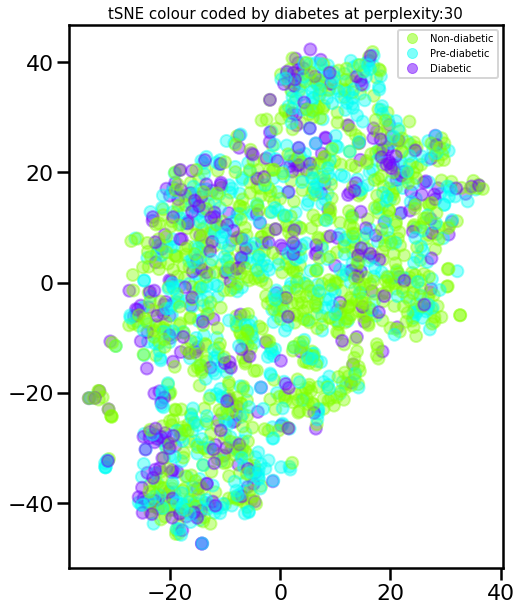

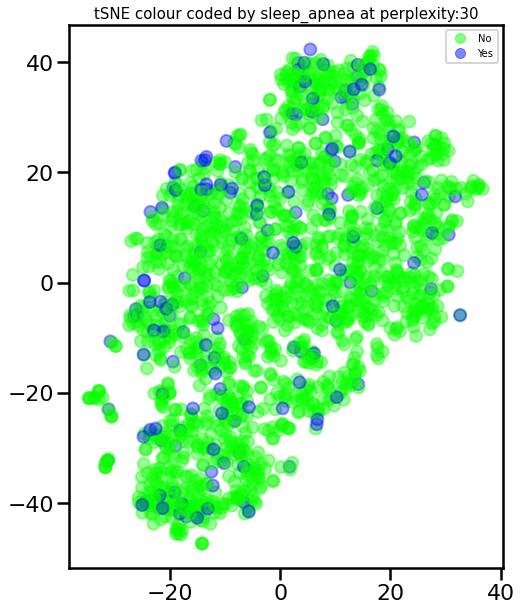

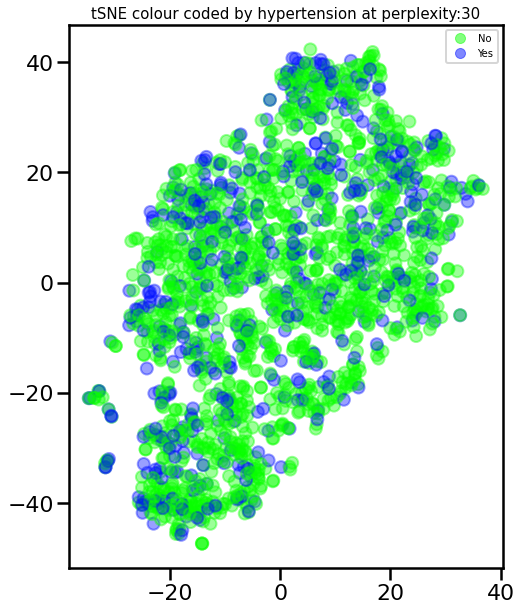

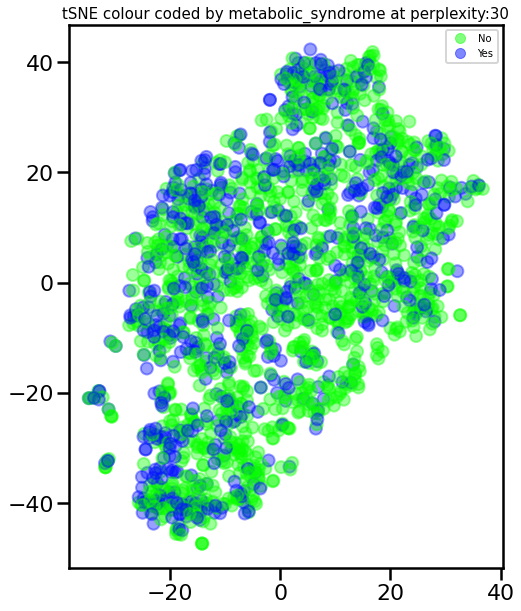

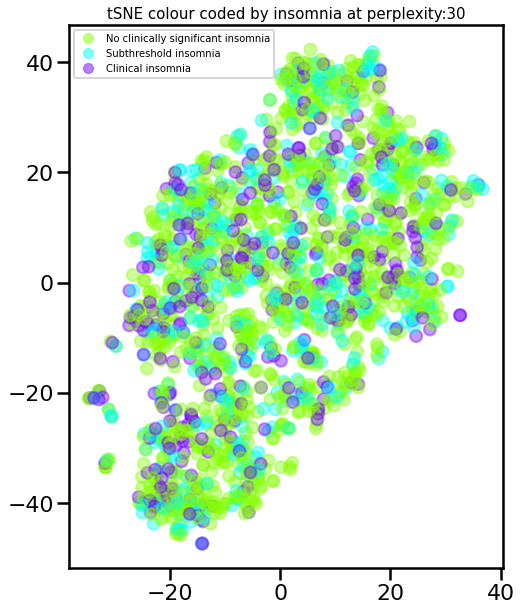

In [78]:
for disease in disease_labels.keys():
    if disease == 'gender':
        continue
    plot_tsne_color_coded_by_condition(disease, 30, disease_labels,tsne_results)